In [57]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools
import importlib
from sklearn.base import clone
import config
importlib.reload(config)
from config import BIN_SIZE, ANALYSIS_MODE, SPECIFIC_GROUP, STRATIFY_BY, SPECIFIC_GROUP_FILE
import helper_functions
importlib.reload(helper_functions)
from helper_functions import preprocess_data, get_fast_pipeline, get_stable_pipeline, get_simple_pipeline, calculate_cs, calculate_stability
import seaborn as sns
from matplotlib.colors import ListedColormap
import ast



In [58]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Alle FutureWarnings ignorieren
warnings.simplefilter(action='ignore', category=FutureWarning)

# Optional: Auch ConvergenceWarnings ignorieren (falls LASSO nicht konvergiert)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.impute")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.linear_model._logistic")
warnings.filterwarnings("ignore", category=RuntimeWarning, module="sklearn.utils.extmath")
warnings.filterwarnings("ignore", message=".*penalty is deprecated.*")


# 0. Check Config

In [59]:
print(ANALYSIS_MODE)
print(SPECIFIC_GROUP)
print(SPECIFIC_GROUP_FILE)
print(STRATIFY_BY)
print(BIN_SIZE)

all_vs_healthy
Pancancer
pancancer
Gender+Age
50000


# 1. Loading of Dataframes

In [60]:
matrix_path = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}_stratified.tsv"
df = pd.read_csv(matrix_path, sep="\t")

clinical_path = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics_stratified.csv"
clinical_df_raw = pd.read_csv(clinical_path, sep=";")


/tmp/ipykernel_1776198/3270183008.py:2: DtypeWarning: Columns (0: Extracted_ID, 1: Study) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(matrix_path, sep="\t")


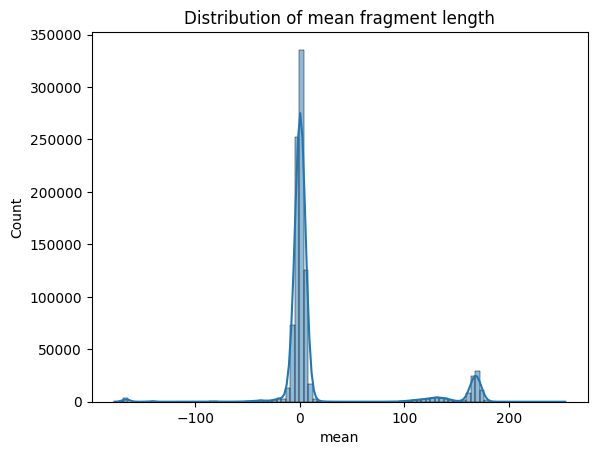

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["mean"], bins=100, kde=True)
plt.title("Distribution of mean fragment length")
plt.show()

## Data Preprocessing

In [62]:
if ANALYSIS_MODE == "specific_vs_healthy":
    clinical_df = clinical_df_raw[
            (clinical_df_raw["Patient Type"] == SPECIFIC_GROUP) |
            (clinical_df_raw["Patient Type"].str.lower() == "healthy")
        ].copy()
else:
    clinical_df = clinical_df_raw.copy()
    
print(f"Specific group: {SPECIFIC_GROUP}")

if STRATIFY_BY == "Gender+Age":
    print("Stratifying by Gender and Age")
    # nehme nur die sample die sowohl age at diagnosis als auch gender haben
    clinical_df = clinical_df[clinical_df["Age at Diagnosis"].notna() & clinical_df["Gender"].notna()]
else:
    clinical_df = clinical_df
    
# Balancing: Sample as many Healthy as there are Cancer samples
cancer_df = clinical_df[clinical_df["Patient Type"].str.lower() != "healthy"]
print(cancer_df.shape)
healthy_df = clinical_df[clinical_df["Patient Type"].str.lower() == "healthy"]
print(healthy_df.shape)
n_cancer = len(cancer_df)

healthy_df = healthy_df.sample(n=n_cancer, random_state=42)
clinical_df = pd.concat([cancer_df, healthy_df]).copy()
print(len(healthy_df))
print(len(cancer_df))

valid_samples = clinical_df["Extracted_ID"].unique()

print(df.head())
print(df.columns)
df = df[df["sample"].isin(valid_samples)].copy()

#df.to_csv(f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv", index=False)

print(f"Number of Samples in Matrix: {df['sample'].nunique()}")
print(f"Number of Bins per Sample: {len(df) / df['sample'].nunique()}")


Specific group: Pancancer
Stratifying by Gender and Age
(78, 21)
(86, 21)
78
78
    sample    group chrom  bin      mean    median     stdev        min  \
0  EE85898  healthy  chr1   18  5.711046  4.213180 -1.160981   2.891532   
1  EE85898  healthy  chr1   21  5.827847  7.195043 -0.382551  -7.014361   
2  EE85898  healthy  chr1   23  2.362936  3.618955  0.978419   3.650431   
3  EE85898  healthy  chr1   25  2.913415  1.389351  3.616282  11.735030   
4  EE85898  healthy  chr1   26  3.125036  2.240639  0.709622   6.399457   

         max  wps_value    start      end       GC Extracted_ID  Study  
0  -1.144616   0.171282   900000   950000  0.63236      EE85898  Jiang  
1   5.779158  -0.246621  1050000  1100000  0.62400      EE85898  Jiang  
2   3.164460  -0.093485  1150000  1200000  0.59202      EE85898  Jiang  
3  34.068773  -0.239364  1250000  1300000  0.60030      EE85898  Jiang  
4   0.979643   0.082042  1300000  1350000  0.64590      EE85898  Jiang  
Index(['sample', 'group', 'chro

In [63]:
print(df[["mean", "median", "stdev", "min", "max", "wps_value"]].mean())
print(df.head())


mean        -0.884789
median      -0.712021
stdev       -0.948494
min          1.511882
max         -4.676231
wps_value   -0.000711
dtype: float64
        sample     group chrom  bin      mean    median     stdev        min  \
93720  EE87789  bileduct  chr1   18 -4.578104 -2.579224 -3.420430   2.017340   
93721  EE87789  bileduct  chr1   21  3.582668  1.378014 -4.063658  20.201636   
93722  EE87789  bileduct  chr1   23  2.723204  3.037290  0.385137  -3.134803   
93723  EE87789  bileduct  chr1   25 -3.069293 -4.499393  0.730413  -2.302143   
93724  EE87789  bileduct  chr1   26 -2.909944  0.988038 -1.539043  -5.959737   

             max  wps_value    start      end       GC Extracted_ID      Study  
93720 -26.829181   0.217644   900000   950000  0.63236      EE87789  Cristiano  
93721  -9.048882  -0.005170  1050000  1100000  0.62400      EE87789  Cristiano  
93722  -0.557981  -0.093246  1150000  1200000  0.59202      EE87789  Cristiano  
93723  -8.170618   0.072532  1250000  1300000  0

# 2. Age for Stratification

In [64]:
# Add new columns for stratification fpr age and gender
age_at_diagnosis = clinical_df_raw["Age at Diagnosis"]
median_age = clinical_df["Age at Diagnosis"].median()
print(f"The median of age at diagnosis is: {median_age}")
clinical_df["AgeGroup"] = pd.cut(

    clinical_df["Age at Diagnosis"],
    bins=[0, median_age-1, 120],
    labels=[f"<{median_age}", f"{median_age}+"]
)


The median of age at diagnosis is: 64.0


# 3. General Function for LASSO perfomance

In [23]:
def run_lasso_for_metrics(df, clinical_df, metrics, fast=True):

    X_train, _, y_train, _ = preprocess_data(df, clinical_df, STRATIFY_BY, metrics)  

    if fast:
        # STAGE 1: fast screening
        fast_pipeline = get_fast_pipeline()
        fast_pipeline.fit(X_train, y_train)
        cv_scores = fast_pipeline.named_steps['lasso_cv'].scores_[1]
        mean_scores = np.mean(cv_scores, axis=0)
        inner_cv_auc = np.max(mean_scores)

        return {"metrics": metrics, 
                "inner_cv_auc": inner_cv_auc
                }
    
    # STAGE 2: full benchmarking for top 10 combinations
    print(f"  > Full benchmarking for {metrics}...", flush=True)


    # Declare new pipeline for this run 
    simple_pipeline = get_simple_pipeline()
    simple_pipeline.fit(X_train, y_train)


    best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

    # fit stable model (1SE) to calculate the ratio
    stable_pipeline = get_stable_pipeline(c_1se)
    stable_pipeline.fit(X_train, y_train)

    n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, outer_cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

    lasso_cv = simple_pipeline.named_steps["lasso_cv"]
    print("C used by fitted LogisticRegressionCV:", float(lasso_cv.C_[0]))
    print("best_c computed from scores:", best_c)


    return {
        "metrics": metrics,
        "best_C": best_c,
        "c_variation": c_variation,
        "c_1se": c_1se,
        "outer_cv_auc": outer_cv_auc,
        "n_features": X_train.shape[1],
        "n_simple": n_simple,
        "n_pars": n_pars,
        "simple_stability_ratio": simple_stability_ratio,
        "pars_stability_ratio": pars_stability_ratio,
        
    }

# 4. Feature Selektion for LASSO (combinations of metrics)

In [56]:
### 2. Aktualisierter Loop: Zweistufen-Suche
# Erst schnelles Screening (Stage 1), dann Detail-Analyse der Top 10 (Stage 2).
import helper_functions
importlib.reload(helper_functions)
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, cv_fold_run, print_performance_table, plot_roc_curves, plot_auc_boxplot

df["bin_id"] = df["chrom"] + "_" + df["start"].astype(str)
metrics_to_test = ["mean", "median", "stdev", "wps_value", "min", "max"]
print("spalten von df", df.colums)

print("STAGE 1: Fast Screening (all combinations)", flush=True)
results_fast = []

for r in range(1, len(metrics_to_test) + 1):
    for combination in itertools.combinations(metrics_to_test, r):
        print(f"Screening combination {combination}...", flush=True)
        res = run_lasso_for_metrics(df, clinical_df, combination, fast=True)
        results_fast.append(res)
        print(f"  > Fast AUC: {res['inner_cv_auc']:.3f}", flush=True)

# Auswahl der Top 10 nach AUC aus dem Screening
top_10 = pd.DataFrame(results_fast).sort_values("inner_cv_auc", ascending=False).head(10)
print(f"\nTop 10 candidates found. Starting Stage 2 Deep Analysis...", flush=True)

print("\nSTAGE 2: Full Benchmarking Top 10", flush=True)
metrics_results = []
for idx, row in top_10.iterrows():
    combination = row['metrics']
    res = run_lasso_for_metrics(df, clinical_df, combination, fast=False)
    metrics_results.append(res)

# Ergebnisse speichern und anzeigen
metrics_results = pd.DataFrame(metrics_results).sort_values("outer_cv_auc", ascending=False)
metrics_results.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_{SPECIFIC_GROUP_FILE}_{BIN_SIZE}.csv", index=False)

print("\n--- FINAL RESULTS (Top 10) ---", flush=True)
display(metrics_results)


KeyError: 'chrom'

In [25]:
# import ast
# importlib.reload(helper_functions)
# from helper_functions import ensure_metrics_list

# #metrics_results = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/outputs/tables/lasso_metrics_results_pancancer_50000.csv")
# # ---- DEBUG: show what types you actually have ----
# type_counts = metrics_results["metrics"].apply(lambda v: type(v).__name__).value_counts()
# print("Type counts in metrics column:\n", type_counts)
# filtered = metrics_results[
#    (metrics_results['pars_stability_ratio'] >= 0.2) &
#    (metrics_results['simple_stability_ratio'] >= 0.2) &
#    (metrics_results['cv_auc'] >= 0.7) &
#    (metrics_results['test_auc'] >= 0.7) &
#    (metrics_results['c_variation'] <= 0.7)
# ].copy()

# filtered["metrics_list"] = filtered["metrics"].apply(ensure_metrics_list)
# filtered["n_metrics"] = filtered["metrics_list"].apply(len)
# filtered = filtered.sort_values(by=["n_metrics", "cv_auc"], ascending=[True, False])
# print(filtered)
# best_metrics = filtered.iloc[0]["metrics_list"]
# print("Final Metric Combination:", best_metrics, type(best_metrics))



In [65]:
print(df)

         sample     group chrom   bin      mean    median     stdev  \
93720   EE87789  bileduct  chr1    18 -4.578104 -2.579224 -3.420430   
93721   EE87789  bileduct  chr1    21  3.582668  1.378014 -4.063658   
93722   EE87789  bileduct  chr1    23  2.723204  3.037290  0.385137   
93723   EE87789  bileduct  chr1    25 -3.069293 -4.499393  0.730413   
93724   EE87789  bileduct  chr1    26 -2.909944  0.988038 -1.539043   
...         ...       ...   ...   ...       ...       ...       ...   
839215  EE88325  bileduct  chr9  2745 -9.819339 -8.672260 -2.816284   
839216  EE88325  bileduct  chr9  2749 -7.963610 -7.672482 -4.784634   
839217  EE88325  bileduct  chr9  2751 -2.112137 -1.908842 -0.031050   
839218  EE88325  bileduct  chr9  2755 -9.135163 -6.679582 -4.366442   
839219  EE88325  bileduct  chr9  2757 -4.544083 -3.655672 -1.727974   

              min        max  wps_value      start        end       GC  \
93720    2.017340 -26.829181   0.217644     900000     950000  0.63236   

# 5. Influence of metric selection on model performance

### 5.1 Lasso Modeling with best C parameter 

The `LogisticRegressionCV` model automatically tried out different values for the parameter `C`. 
Here we visualize how the accuracy of the model changes with `C`.

- **Small C**: Strong regularization (model is “forced” to find simple solutions). Risk of underfitting.
- **Large C**: Weak regularization (model can be more complex). Risk of overfitting.
- **Best C**: The value that achieved the best balance and thus the highest score in cross-validation (CV).

The Reciever operating characteristic curve plots the true positive (TP) rate versus the false positive (FP) rate at different classification thresholds. 

The thresholds are different probability cutoffs that separate the two classes in binary classification. It uses probability to tell us how well a model separates the classes.

In [66]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability
import helper_functions
importlib.reload(helper_functions)

best_metrics = ['mean', 'median', 'stdev', 'wps_value']
print(f"Re-training model with best metrics: {best_metrics}")
        
print("Spalten im DF:", df.columns.tolist())    

X_train, X_test, y_train, y_test = preprocess_data(df, clinical_df, STRATIFY_BY, best_metrics)

# Fit
simple_pipeline = get_simple_pipeline()
simple_pipeline.fit(X_train, y_train)

# Get C values
best_c, c_1se, best_score, threshold, mean_scores, sem_scores, cs = calculate_cs(simple_pipeline)

print(f"Best C (max mean): {best_c:.6f} with AUC: {best_score:.4f}")
print(f"c_1se (parsimonious): {c_1se:.6f} (Threshold: {threshold:.4f})")


# --- STABILERES MODELL MIT C_1SE ---
stable_pipeline = get_stable_pipeline(c_1se)
stable_pipeline.fit(X_train, y_train)

n_stable, n_simple, n_pars, simple_stability_ratio, pars_stability_ratio, c_variation, outer_cv_auc = calculate_stability(X_train, y_train, simple_pipeline, stable_pipeline)

print(f"n_stable: {n_stable}")
print(f"n_simple: {n_simple}")
print(f"n_pars: {n_pars}")
print(f"simple_stability_ratio: {simple_stability_ratio}")
print(f"pars_stability_ratio: {pars_stability_ratio}")
print(f"c_variation: {c_variation}")
print(f"outer_cv_auc: {outer_cv_auc}")



stability_df_output = pd.DataFrame({
    'best_c': [best_c],
    'best_score': [best_score],
    'c_1se': [c_1se],
    'threshold': [threshold],
    'n_stable': [n_stable],
    'n_simple': [n_simple],
    'n_pars': [n_pars],
    'simple_stability_ratio': [simple_stability_ratio],
    'pars_stability_ratio': [pars_stability_ratio],
    'c_variation': [c_variation],
    'outer_cv_auc': [outer_cv_auc]
})




Re-training model with best metrics: ['mean', 'median', 'stdev', 'wps_value']
Spalten im DF: ['sample', 'group', 'chrom', 'bin', 'mean', 'median', 'stdev', 'min', 'max', 'wps_value', 'start', 'end', 'GC', 'Extracted_ID', 'Study']
No NaNs in dataframe


Best C (max mean): 4.291934 with AUC: 0.8187
c_1se (parsimonious): 0.100000 (Threshold: 0.7946)
Fold 1/5...
  AUC = 0.885, Best C = 7.543120063354615
Fold 2/5...
  AUC = 0.814, Best C = 10.0
Fold 3/5...
  AUC = 0.814, Best C = 5.689866029018296
Fold 4/5...
  AUC = 0.662, Best C = 7.543120063354615
Fold 5/5...
  AUC = 0.937, Best C = 5.17947467923121
n_stable: 13
n_simple: 247
n_pars: 37
simple_stability_ratio: 0.05263157894736842
pars_stability_ratio: 0.24324324324324326
c_variation: 0.10130345833461925
outer_cv_auc: 0.8224442224442224


In [67]:
import joblib

joblib.dump(stable_pipeline, 'final_lasso_model.joblib')
joblib.dump(X_train.columns.tolist(), 'model_features.joblib')

joblib.dump(simple_pipeline, 'simple_lasso_model.joblib')

print("Modelle und Features gespeichert!")


Modelle und Features gespeichert!


In [28]:
# Simple model 
y_prob_best_test = simple_pipeline.predict_proba(X_test)[:, 1]
y_prob_best_train = simple_pipeline.predict_proba(X_train)[:, 1]

fpr_best_test, tpr_best_test, _ = roc_curve(y_test, y_prob_best_test)
fpr_best_train, tpr_best_train, _ = roc_curve(y_train, y_prob_best_train)

auc_best_train = roc_auc_score(y_train, y_prob_best_train)
auc_best_test = roc_auc_score(y_test, y_prob_best_test)

# Parsimonious model 
y_prob_1se_test = stable_pipeline.predict_proba(X_test)[:, 1]
y_prob_1se_train = stable_pipeline.predict_proba(X_train)[:, 1]

fpr_1se_test, tpr_1se_test, _ = roc_curve(y_test, y_prob_1se_test)
fpr_1se_train, tpr_1se_train, _ = roc_curve(y_train, y_prob_1se_train)

auc_1se_train = roc_auc_score(y_train, y_prob_1se_train)
auc_1se_test = roc_auc_score(y_test, y_prob_1se_test)

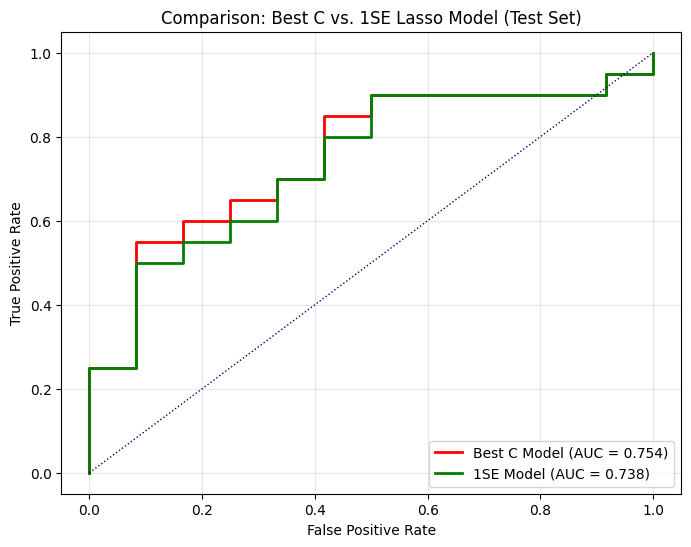

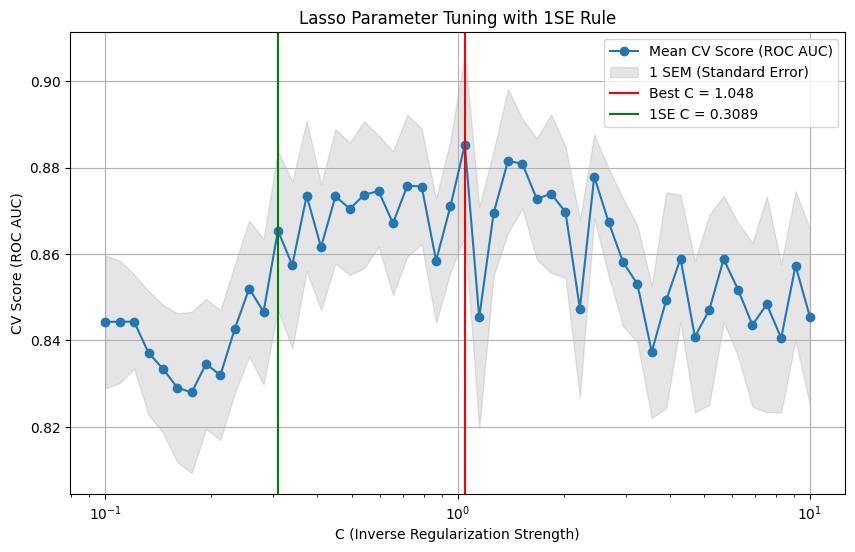

In [29]:

# 3. Create Common Plot
plt.figure(figsize=(8, 6))

# Curve 1: Best C (e.g., in Blue)
plt.plot(fpr_best_test, tpr_best_test, color='red', lw=2, 
         label=f'Best C Model (AUC = {auc_best_test:.3f})')

# Kurve 2: 1SE Model (z.B. in Grün oder Orange)
plt.plot(fpr_1se_test, tpr_1se_test, color='green', lw=2,
         label=f'1SE Model (AUC = {auc_1se_test:.3f})')

# Diagonale (Zufallslinie)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle=':')

plt.title('Comparison: Best C vs. 1SE Lasso Model (Test Set)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/roc_curve_both.png")


plt.show()

# --- Lasso Parameter Tuning Plot ---
plt.figure(figsize=(10,6))
plt.semilogx(cs, mean_scores, marker='o', label='Mean CV Score (ROC AUC)')
plt.fill_between(cs, mean_scores - sem_scores, mean_scores + sem_scores, alpha=0.2, color='gray', label='1 SEM (Standard Error)')
plt.axvline(best_c, color='r', label=f'Best C = {best_c:.3f}')
plt.axvline(c_1se, color='g', label=f'1SE C = {c_1se:.4f}')
plt.title("Lasso Parameter Tuning with 1SE Rule")
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Score (ROC AUC)")
plt.legend()
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/lasso_parameter_tuning.png")
plt.show()


stability_df_output['test auc c'] = auc_best_test
stability_df_output['test auc 1se'] = auc_1se_test




## 5.2 Training vs. Test with best model 

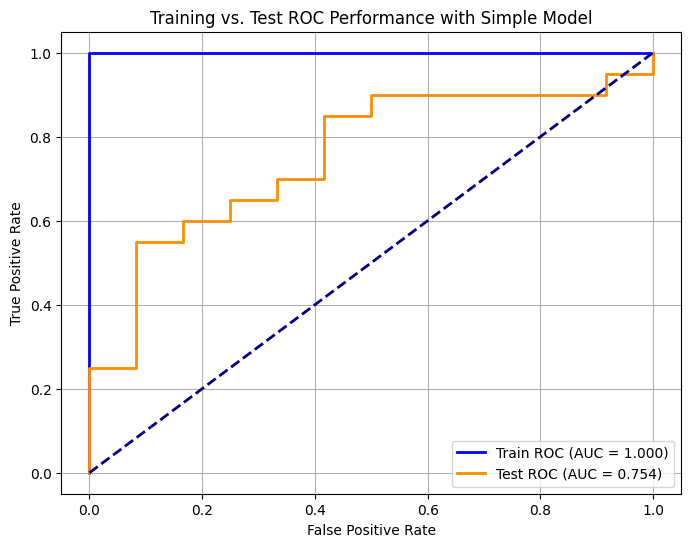

In [30]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_best_train, tpr_best_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_best_train:.3f})')
plt.plot(fpr_best_test, tpr_best_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_best_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Simple Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_BEST_C.png")

plt.show()
stability_df_output['train auc c'] = auc_best_train

## 5.3 Training vs. Test with 1SE Model

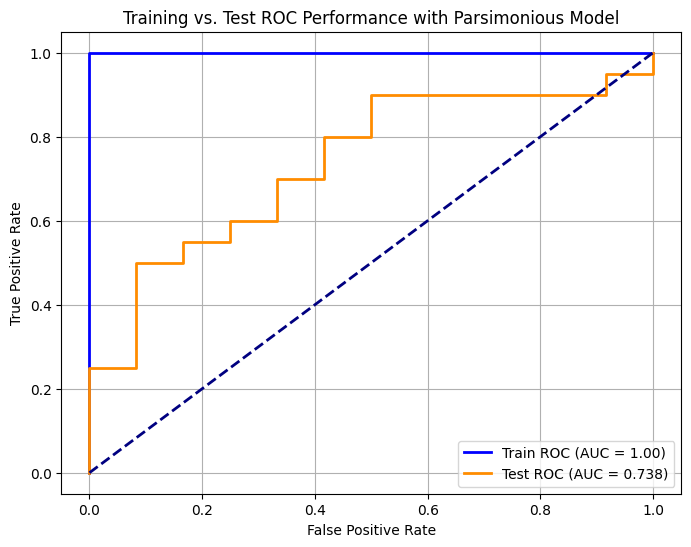

In [31]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_1se_train, tpr_1se_train, color='blue', lw=2, label=f'Train ROC (AUC = {auc_1se_train:.2f})')
plt.plot(fpr_1se_test, tpr_1se_test, color='darkorange', lw=2, label=f'Test ROC (AUC = {auc_1se_test:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.title('Training vs. Test ROC Performance with Parsimonious Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/Training_Test_1SE_C.png")
plt.show()

stability_df_output['train auc 1se'] = auc_1se_train

# 6. Selected Important Features


## 6.1 Pipeline with best model

                  Feature  Coefficient
0     median_chr10_100000          0.0
1  median_chr10_100950000          0.0
2  median_chr10_101050000          0.0
3  median_chr10_101400000          0.0
4  median_chr10_101550000          0.0
SINGLE MODEL (Best C)
Number of Important Features (Best Model): 90

Top Features (Best Model - Positive = Indicative for Cancer):


<Axes: title={'center': 'Top Features (Best Model - Positive = Indicative for Cancer)'}, ylabel='Feature'>

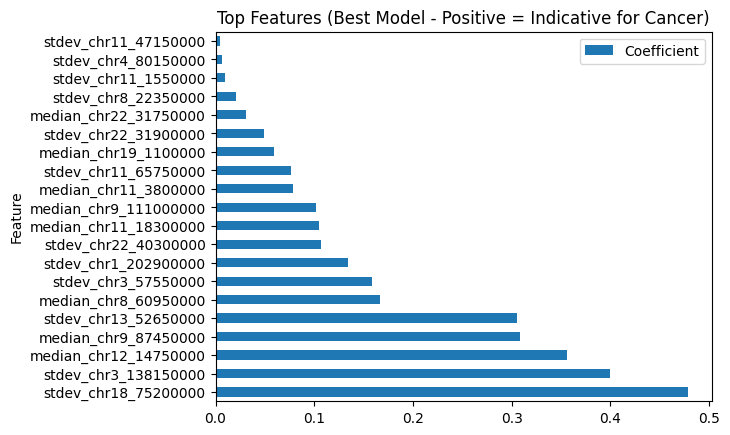

In [32]:
from cv_lasso_single_fold import cross_validation, analyze_feature_stability, plot_roc_curves, plot_auc_boxplot

lasso_model = simple_pipeline.named_steps['lasso_cv']

coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": lasso_model.coef_[0]
})
print(coef_df.head())
important_features = coef_df[coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("SINGLE MODEL (Best C)")
print(f"Number of Important Features (Best Model): {len(important_features)}")
print("\nTop Features (Best Model - Positive = Indicative for Cancer):")
important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Best Model - Positive = Indicative for Cancer)")


## 6.2 Stable Pipeline with 1SE model 


STABLE MODEL (c_1se):
Number of Important Features (Stable Model): 50

Top Features (Stable Model - Positive = Indicative for Cancer):


COMPARISON:
Best C Model: 90 features selected
1SE Model:    50 features selected
Difference:   40 fewer features in 1SE model
stable_important_features:                      Feature  Coefficient
5844    stdev_chr18_75200000     0.292722
559    median_chr12_14750000     0.272453
7190    stdev_chr3_138150000     0.267533
5026    stdev_chr13_52650000     0.201385
4233    median_chr9_87450000     0.186444
7333     stdev_chr3_57550000     0.084380
6308    stdev_chr1_202900000     0.068436
281    median_chr11_18300000     0.022134
4042    median_chr8_60950000     0.011830
1608    median_chr19_1100000     0.002443
4310   stdev_chr10_126450000    -0.001536
7164     stdev_chr3_12450000    -0.004771
6273      stdev_chr1_1750000    -0.006382
4130   median_chr9_130400000    -0.012278
2299   median_chr20_10400000    -0.015331
4291   stdev_chr10_114600000    -0.01

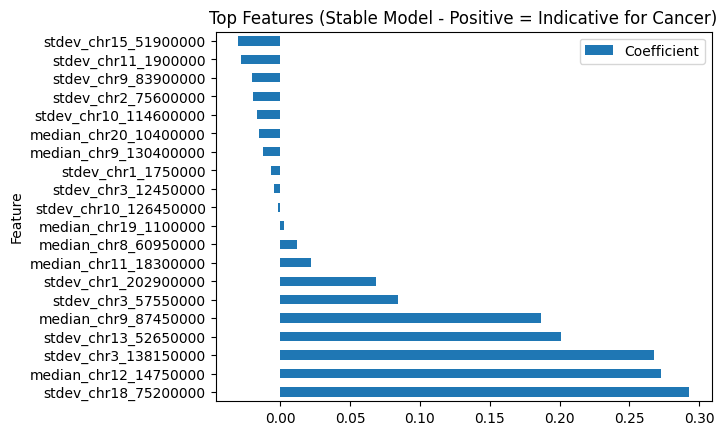

In [33]:

stable_model = stable_pipeline.named_steps['stable_model']

stable_coef_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": stable_model.coef_[0]
})

stable_important_features = stable_coef_df[stable_coef_df["Coefficient"] != 0].sort_values(by="Coefficient", ascending=False)

print("STABLE MODEL (c_1se):")
print(f"Number of Important Features (Stable Model): {len(stable_important_features)}")
print(f"\nTop Features (Stable Model - Positive = Indicative for Cancer):")
stable_important_features.head(20).plot.barh(x="Feature", y="Coefficient", title="Top Features (Stable Model - Positive = Indicative for Cancer)")

print("\n")
print("COMPARISON:")
print(f"Best C Model: {len(important_features)} features selected")
print(f"1SE Model:    {len(stable_important_features)} features selected")
print(f"Difference:   {len(important_features) - len(stable_important_features)} fewer features in 1SE model")

print(f"stable_important_features: {stable_important_features}")


# 7. Feature Stability Analysis (Cross-Validation) 


Running 5-Fold Cross-Validation for Feature Stability.
Fold 1/5...


  AUC = 0.910, Best C = 4.291934260128776
Fold 2/5...
  AUC = 0.865, Best C = 3.5564803062231287
Fold 3/5...
  AUC = 0.846, Best C = 2.9470517025518097
Fold 4/5...
  AUC = 0.675, Best C = 6.866488450042998
Fold 5/5...
  AUC = 0.874, Best C = 8.286427728546842


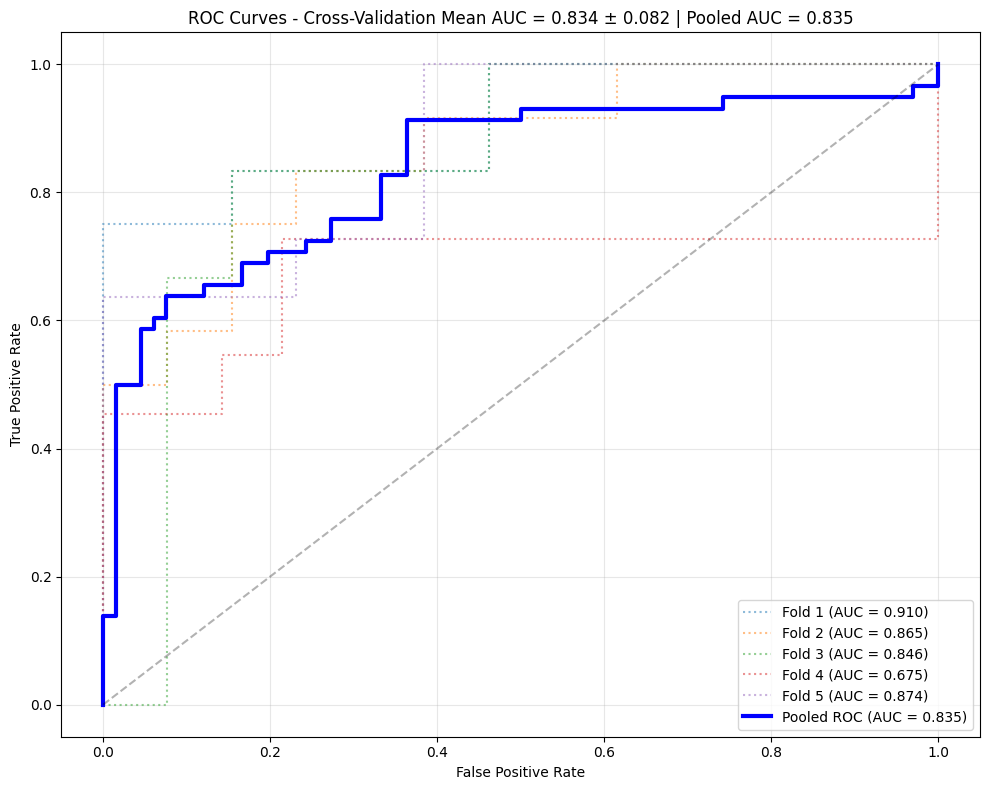

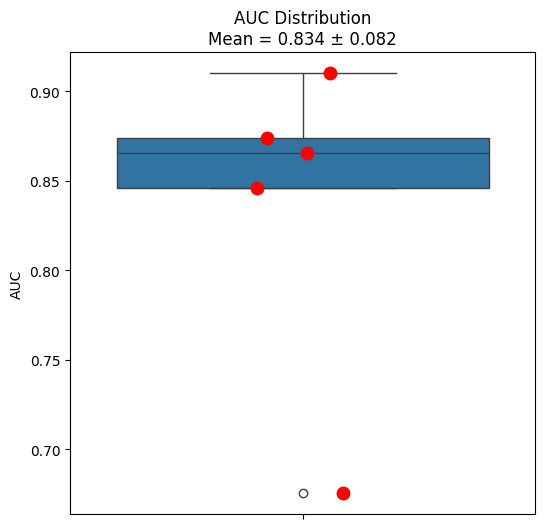

In [34]:
import importlib
import cv_lasso_single_fold
importlib.reload(cv_lasso_single_fold)
from cv_lasso_single_fold import plot_roc_curves, plot_auc_boxplot
print("Running 5-Fold Cross-Validation for Feature Stability.")


# hier macht es keinen sinn die stable pipeline zu nutzen, da in jedem fold mit dem gleichen c wert (c_1se) trainiert wird
cv_results = cross_validation(X_train, y_train, simple_pipeline, n_folds=5)

plot_roc_curves(cv_results, SPECIFIC_GROUP_FILE)
plot_auc_boxplot(cv_results, SPECIFIC_GROUP_FILE)


## 7.2 Table with Statistical Values

In [35]:
from cv_lasso_single_fold import print_performance_table
stat_table = print_performance_table(cv_results)
print(stat_table)

#speicher die stat tabelle
stat_table.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stat_table_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)

'''
Accuracy: Anteil korrekt klassifizierter Samples
Sensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)
Specificity: Wie viele Gesunde wurden korrekt erkannt
Precision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs
'''


   Fold       AUC  Accuracy  Sensitivity  Specificity  Precision    Best_C  \
0     1  0.910256  0.760000     0.833333     0.692308   0.714286  4.291934   
1     2  0.865385  0.760000     0.666667     0.846154   0.800000  3.556480   
2     3  0.846154  0.760000     0.833333     0.692308   0.714286  2.947052   
3     4  0.675325  0.680000     0.545455     0.785714   0.666667  6.866488   
4     5  0.874126  0.708333     0.636364     0.769231   0.700000  8.286428   
5  Mean  0.834249  0.733667     0.703030     0.757143   0.719048  5.189676   
6   Std  0.091836  0.037424     0.127038     0.065751   0.049258  2.286056   

   N_Features  
0  138.000000  
1  142.000000  
2  131.000000  
3  175.000000  
4  197.000000  
5  156.600000  
6   28.218788  


'\nAccuracy: Anteil korrekt klassifizierter Samples\nSensitivity: Wie viele Krebs-Patienten wurden erkannt (wichtig!)\nSpecificity: Wie viele Gesunde wurden korrekt erkannt\nPrecision: Von allen als "Krebs" vorhergesagten, wie viele waren wirklich Krebs\n'

## 7.3 Feature Stability Analyse



Top Stable Features (Selected across multiple folds):
                   Feature  Frequency  Frequency_Percent  Mean_Coef
87    stdev_chr18_75200000          5              100.0   0.329307
74    stdev_chr13_52650000          5              100.0   0.161774
56    median_chr8_60950000          5              100.0   0.112587
106   stdev_chr21_43400000          5              100.0  -0.090801
59   median_chr9_130400000          5              100.0  -0.126149


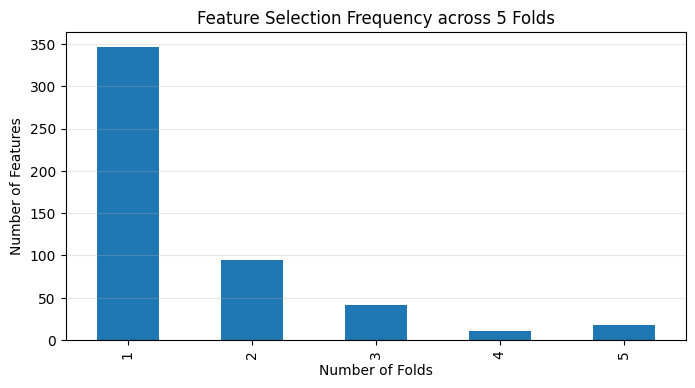

Features in ALL 5 folds: 17


In [36]:
stability_df = analyze_feature_stability(cv_results)

stable_in_all = stability_df[stability_df['Frequency'] == 5]
print("\nTop Stable Features (Selected across multiple folds):")
print(stability_df.head(5))


plt.figure(figsize=(8, 4))
stability_df['Frequency'].value_counts().sort_index().plot(kind='bar')
plt.title('Feature Selection Frequency across 5 Folds')
plt.xlabel('Number of Folds')
plt.ylabel('Number of Features')
plt.grid(axis='y', alpha=0.3)
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_frequency.png")
plt.show()
print(f"Features in ALL 5 folds: {len(stable_in_all)}")

## 7.4 Feature Overlap Heatmap 


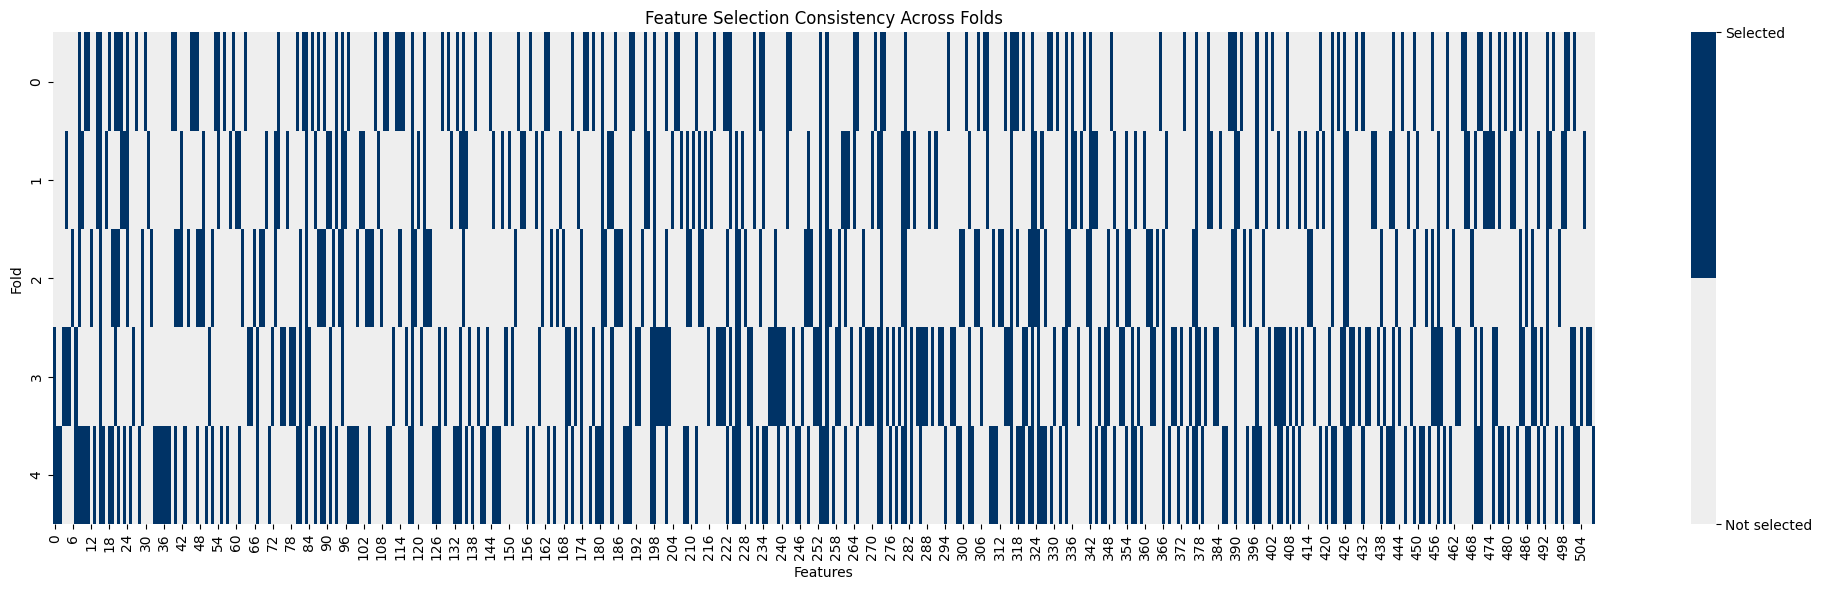

In [37]:
all_features = sorted(list({
    feat
    for e in cv_results
    for feat in e['selected_features'].keys()
}))

matrix = np.zeros((5, len(all_features)))

for i, e in enumerate(cv_results):
    for j, feat in enumerate(all_features):
        if feat in e['selected_features']:
            matrix[i, j] = 1

# --- Binary colormap ---
cmap = ListedColormap(["#eeeeee", "#003366"])

plt.figure(figsize=(20, 6))
ax = sns.heatmap(
    matrix,
    cmap=cmap,
    vmin=0,
    vmax=1,
    cbar=True,
    cbar_kws={"ticks": [0, 1]}
)

# Custom colorbar labels
colorbar = ax.collections[0].colorbar
colorbar.set_ticklabels(["Not selected", "Selected"])

plt.xlabel("Features")
plt.ylabel("Fold")
plt.title("Feature Selection Consistency Across Folds")
plt.tight_layout()
plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/outputs/plots/{SPECIFIC_GROUP_FILE}/{BIN_SIZE}/feature_selection_heatmap.png")
plt.show()


## 7.5 Saving stable features in file for comparison

In [38]:
import pandas as pd
from itertools import combinations

def extract_genomic_position(feature):
    if 'chr' in feature:
        return feature[feature.index('chr'):]
    return feature

metrics = {
    "mean": "stable_features_['mean']_50000_fold.csv",
    "stdev": "stable_features_['stdev']_50000_fold.csv",
    "wps": "stable_features_['wps_value']_50000_fold.csv",
    "mean_median_stdev": "stable_features_['mean', 'median', 'stdev']_50000_fold.csv"
}

base_path = "/labmed/workspace/lotta/finaletoolkit/outputs/statistics/"

feature_sets = {}

for metric, file in metrics.items():
    df = pd.read_csv(base_path + file)
    cleaned = {extract_genomic_position(f) for f in df['Feature']}
    feature_sets[metric] = cleaned


for (m1, f1), (m2, f2) in combinations(feature_sets.items(), 2):
    intersection = f1 & f2
    print(
        f"Intersection between {m1} and {m2}: "
        f"{len(intersection)} stable features\n{intersection}\n"
    )


Intersection between mean and stdev: 4 stable features
{'chr1_248500000', 'chr6_20400000', 'chr1_202900000', 'chr7_149100000'}

Intersection between mean and wps: 8 stable features
{'chr17_4800000', 'chr18_3850000', 'chr1_2150000', 'chr8_8950000', 'chr17_75200000', 'chr1_1600000', 'chr8_60950000', 'chr1_30700000'}

Intersection between mean and mean_median_stdev: 7 stable features
{'chr2_222600000', 'chr16_28350000', 'chr19_6700000', 'chr1_235300000', 'chr7_63350000', 'chr15_43650000', 'chr9_135700000'}

Intersection between stdev and wps: 0 stable features
set()

Intersection between stdev and mean_median_stdev: 0 stable features
set()

Intersection between wps and mean_median_stdev: 0 stable features
set()



# 8. Visualize the ROC Calculation (Label, Probability)

In [39]:
# 1. Get the probabilities for the test set 
y_prob_test = simple_pipeline.predict_proba(X_test)[:, 1]

# 2. Create a DataFrame to map predictions to sample IDs
test_results = pd.DataFrame({
    'Sample_ID': X_test.index,
    'True_Label': y_test,
    'Probability_Cancer': y_prob_test
})

# 3. Sort the results by probability    
test_results = test_results.sort_values(by='Probability_Cancer', ascending=False).reset_index(drop=True)

# 4. Print the top 5 predictions
print("Detailed predicitions for test set:")
print(test_results.head(5))


Detailed predicitions for test set:
  Sample_ID  True_Label  Probability_Cancer
0   EE88317           1            0.998693
1   EE88298           1            0.996884
2   EE88310           1            0.969082
3   EE87919           1            0.962161
4   EE87911           1            0.957200


In [40]:
# Falsch-Negative (Krebs als gesund vorhergesagt)
fn_proben = test_results[(test_results['True_Label'] == 1) & (test_results['Probability_Cancer'] < 0.3)]

# Falsch-Positive (Gesund als Krebs vorhergesagt)
fp_proben = test_results[(test_results['True_Label'] == 0) & (test_results['Probability_Cancer'] > 0.7)]

# Merge outliers with test_results to get the probabilities
outliers_meta = pd.concat([fn_proben, fp_proben])
if not outliers_meta.empty:
    ausreisser_klinik = clinical_df.merge(outliers_meta[['Sample_ID', 'Probability_Cancer', 'True_Label']], 
                                         left_on='Extracted_ID', right_on='Sample_ID')
    print(f"Found outliers with threshold (FN < 0.3, FP > 0.7): {len(ausreisser_klinik)}")
    print(ausreisser_klinik[['Extracted_ID', 'Patient Type', 'Gender', 'Probability_Cancer']])
else:
    print("No outliers found.")


Found outliers with threshold (FN < 0.3, FP > 0.7): 9
  Extracted_ID       Patient Type Gender  Probability_Cancer
0      EE87865  Colorectal Cancer      F            0.122087
1      EE87872  Colorectal Cancer      F            0.116961
2      EE87877  Colorectal Cancer      F            0.180635
3      EE87886  Colorectal Cancer      M            0.013430
4      EE87906     Gastric Cancer      M            0.073223
5      EE87918     Gastric Cancer      M            0.222090
6      EE88305  Pancreatic Cancer      M            0.135416
7      EE88315  Pancreatic Cancer      M            0.006027
8      EE87971            Healthy      F            0.952529


In [41]:
stability_df_output.to_csv(f"/labmed/workspace/lotta/finaletoolkit/outputs/tables/stability_df_{BIN_SIZE}_{SPECIFIC_GROUP_FILE}.csv", index=False)

In [42]:
print("Train label distribution:", np.unique(y_train, return_counts=True))


Train label distribution: (array([0, 1]), array([66, 58]))


In [43]:
model = simple_pipeline.named_steps["lasso_cv"]

coefs = model.coef_[0]
features = X_train.columns

coef_df = pd.DataFrame({
    "feature": features,
    "coef": coefs
})

coef_df.sort_values("coef", ascending=False).head(20)


,feature,coef
5844,stdev_chr18_75200000,0.478530
7190,stdev_chr3_138150000,0.399693
559,median_chr12_14750000,0.356335
4233,median_chr9_87450000,0.308186
5026,stdev_chr13_52650000,0.305441
4042,median_chr8_60950000,0.166820
7333,stdev_chr3_57550000,0.158557
6308,stdev_chr1_202900000,0.133968
6802,stdev_chr22_40300000,0.107168
281,median_chr11_18300000,0.104466


In [44]:
print("Mean fragment length per class:")
print("Healthy (0):", X_train[y_train==0].mean().mean())
print("Cancer  (1):", X_train[y_train==1].mean().mean())


Mean fragment length per class:
Healthy (0): -0.0018926945777202207
Cancer  (1): -1.81455545887721


In [45]:
# Differenz pro Feature: Cancer - Healthy
delta = X_train[y_train==1].mean() - X_train[y_train==0].mean()

# Welche mean_-Features sind bei Cancer höher?
delta_mean = delta[delta.index.str.startswith("mean_")].sort_values(ascending=False)

delta_mean.head(20), delta_mean.tail(20)


(Series([], dtype: float64), Series([], dtype: float64))

In [46]:
coef = pd.Series(simple_pipeline.named_steps["lasso_cv"].coef_[0], index=X_train.columns)

# Nur Features, die das Modell nutzt
selected = coef[coef != 0].sort_values()

check = pd.DataFrame({
    "coef": selected,
    "delta_cancer_minus_healthy": delta[selected.index]
}).sort_values("coef", ascending=False)

check.head(30)


,coef,delta_cancer_minus_healthy
stdev_chr18_75200000,0.478530,-0.419816
stdev_chr3_138150000,0.399693,0.010040
median_chr12_14750000,0.356335,0.777692
median_chr9_87450000,0.308186,-0.008247
stdev_chr13_52650000,0.305441,-0.089297
median_chr8_60950000,0.166820,-0.395447
stdev_chr3_57550000,0.158557,-0.409549
stdev_chr1_202900000,0.133968,-0.048793
stdev_chr22_40300000,0.107168,-0.053998
median_chr11_18300000,0.104466,0.559436


In [47]:
np.corrcoef(coef[selected.index], delta[selected.index])


array([[1.        , 0.30751818],
       [0.30751818, 1.        ]])